In [1]:
# =======================
# 0. Install Required Packages
# =======================
!pip install numpy pandas scikit-learn matplotlib seaborn xgboost lightgbm catboost joblib shap dice-ml optuna umap-learn streamlit plotly


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 89.0 MB/s eta 0:00:00


In [2]:
# =======================
# 0. Import Libraries
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier

import shap
import optuna
import warnings
warnings.filterwarnings('ignore')

RANDOM_SEED = 42


In [3]:
# =======================
# 1. Load & Inspect Dataset
# =======================
df = pd.read_csv("/content/drive/MyDrive/Joy Research/Crop_recommendation.csv")
FEATURES = ['N','P','K','temperature','humidity','ph','rainfall']
TARGET = 'label'

# Check missing values
print("missing value")
print(df.isnull().sum())


missing value
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


Dataset shape: (2200, 8)


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


,N,P,K,temperature,humidity,ph,rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


,count
label,
rice,100
maize,100
chickpea,100
kidneybeans,100
pigeonpeas,100
mothbeans,100
mungbean,100
blackgram,100
lentil,100


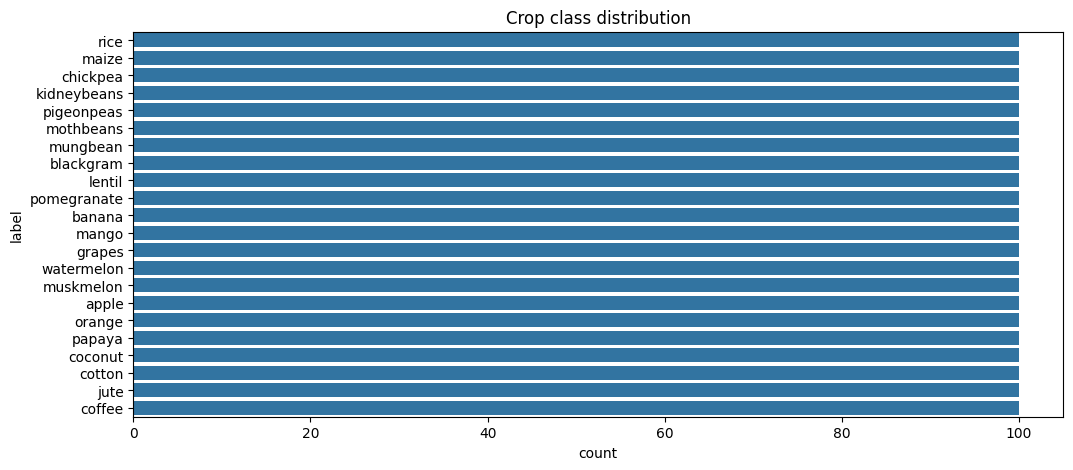

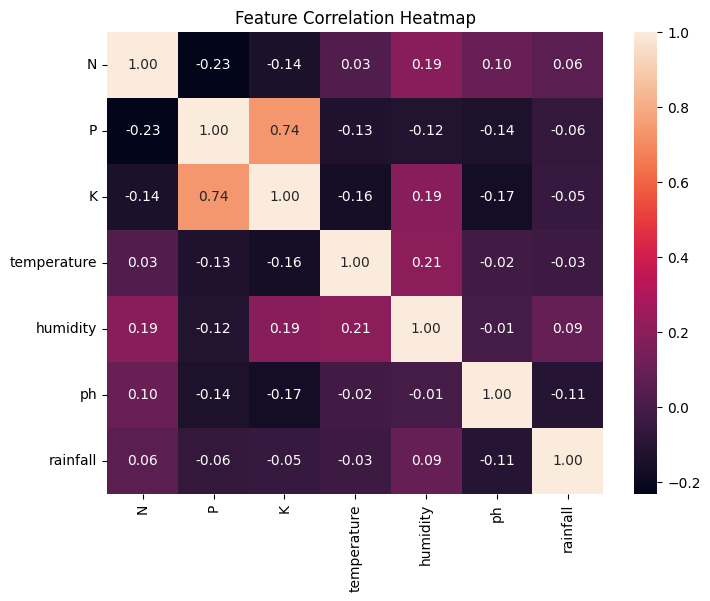

In [4]:
# =======================
# 2. Load Dataset & EDA
# =======================
df = pd.read_csv("/content/drive/MyDrive/Joy Research/Crop_recommendation.csv") # Change path if needed
print("Dataset shape:", df.shape)
display(df.head())
display(df.describe())
display(df['label'].value_counts())

# Class distribution
plt.figure(figsize=(12,5))
sns.countplot(y='label', data=df, order=df['label'].value_counts().index)
plt.title("Crop class distribution")
plt.show()

# Feature correlation
plt.figure(figsize=(8,6))
sns.heatmap(df[['N','P','K','temperature','humidity','ph','rainfall']].corr(), annot=True, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [5]:
# =======================
# 3. Preprocessing
# =======================
FEATURES = ['N','P','K','temperature','humidity','ph','rainfall']
TARGET = 'label'

le = LabelEncoder()
df['label_enc'] = le.fit_transform(df[TARGET])

X = df[FEATURES]
y = df['label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save scaler and encoder
joblib.dump(scaler, "scaler.pkl")
joblib.dump(le, "label_encoder.pkl")


['label_encoder.pkl']

In [6]:
# =======================
# 4. Utility Functions
# =======================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
import joblib
import numpy as np

def save_model_if_better(model, name, acc, best_dict):
    """Save the model if it achieves a higher test accuracy than previous best."""
    if acc > best_dict.get(name, -1):
        best_dict[name] = acc
        joblib.dump(model, f"{name}_best.pkl")
        print(f"✅ Saved best {name} with acc={acc:.4f}")
    return best_dict


def plot_confusion_matrix(y_true, y_pred, labels, title="Confusion Matrix"):
    """Plot confusion matrix with annotations (publication-ready)."""
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels,
                annot_kws={"size": 8})
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


def model_report(name, model, Xs_train, y_train, Xs_test, y_test, le):
    """Train & evaluate model, print metrics, and plot confusion matrix."""
    # Train Accuracy
    y_train_pred = model.predict(Xs_train)
    train_acc = accuracy_score(y_train, y_train_pred)

    # Test Accuracy
    y_pred = model.predict(Xs_test)
    test_acc = accuracy_score(y_test, y_pred)

    print(f"\n=== {name} Performance ===")
    print(f"Train Accuracy: {train_acc:.4f} | Test Accuracy: {test_acc:.4f}")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # Confusion Matrix
    plot_confusion_matrix(y_test, y_pred, le.classes_, title=f"{name} Confusion Matrix")

    return train_acc, test_acc


def cv_score_model(model, X, y, cv=5):
    """Perform cross-validation and return mean accuracy."""
    kf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=RANDOM_SEED)
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy', n_jobs=-1)
    print(f"CV scores: {np.round(scores, 4)} | mean={scores.mean():.4f} ± {scores.std():.4f}")
    return scores.mean()


=== RandomForest Performance ===
Train Accuracy: 1.0000 | Test Accuracy: 0.9955
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      1.00      1.00        20
       maize       0.95      1.00      0.98        20
       mango       1.00      1.00      1.00        20
   mothbeans       1.00      1.00      1.00        20
    mungbean       1.00      1.00      1.00        20
   muskmelon       1.00      1.00      1.00        20


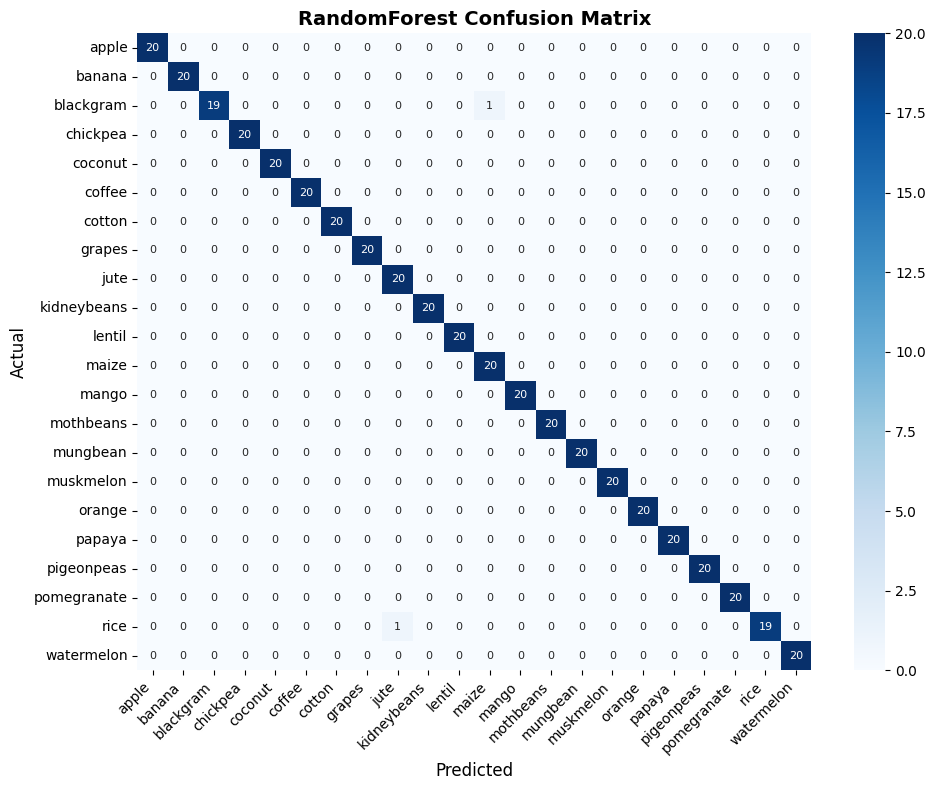

CV scores: [1.     0.9972 0.9886 0.9886 0.9943] | mean=0.9938 ± 0.0045
✅ Saved best RandomForest with acc=0.9955

=== XGBoost Performance ===
Train Accuracy: 1.0000 | Test Accuracy: 0.9886
              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        20
      banana       1.00      1.00      1.00        20
   blackgram       0.95      1.00      0.98        20
    chickpea       1.00      1.00      1.00        20
     coconut       1.00      1.00      1.00        20
      coffee       1.00      1.00      1.00        20
      cotton       1.00      1.00      1.00        20
      grapes       1.00      1.00      1.00        20
        jute       0.95      1.00      0.98        20
 kidneybeans       1.00      1.00      1.00        20
      lentil       1.00      0.85      0.92        20
       maize       1.00      1.00      1.00        20
       mango       1.00      1.00      1.00        20
   mothbeans       0.95      1.00      0.98        20


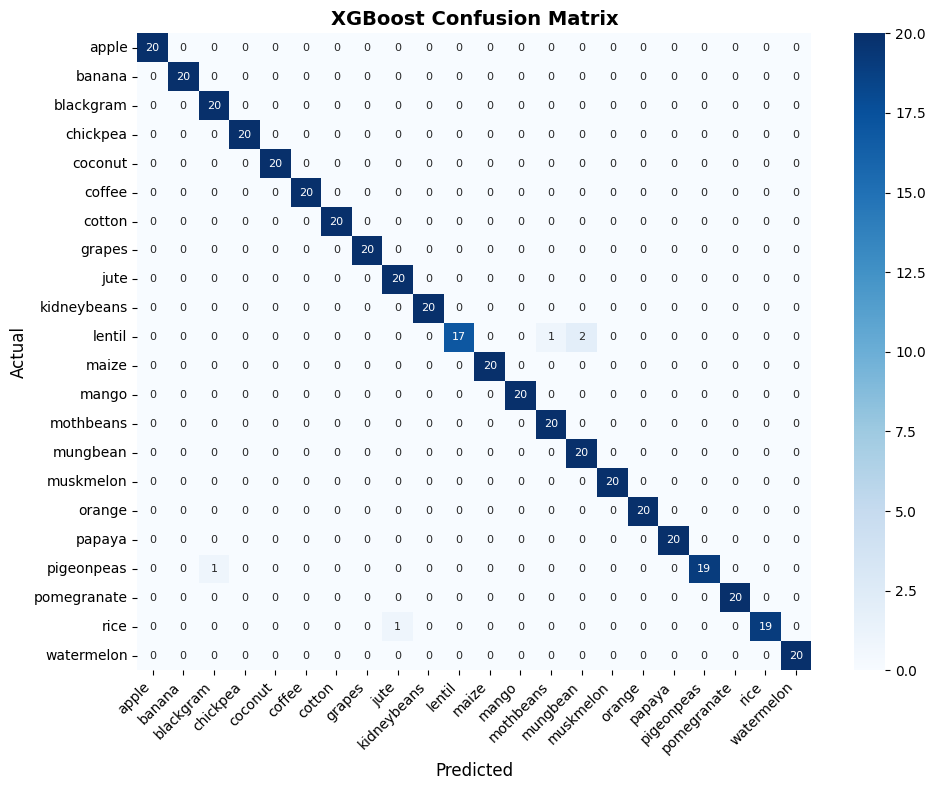

CV scores: [0.9915 0.9886 0.9972 0.9915 0.9886] | mean=0.9915 ± 0.0031
✅ Saved best XGBoost with acc=0.9886
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1332
[LightGBM] [Info] Number of data points in the train set: 1760, number of used features: 7
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] [Info] Start training from score -3.091042
[LightGBM] 

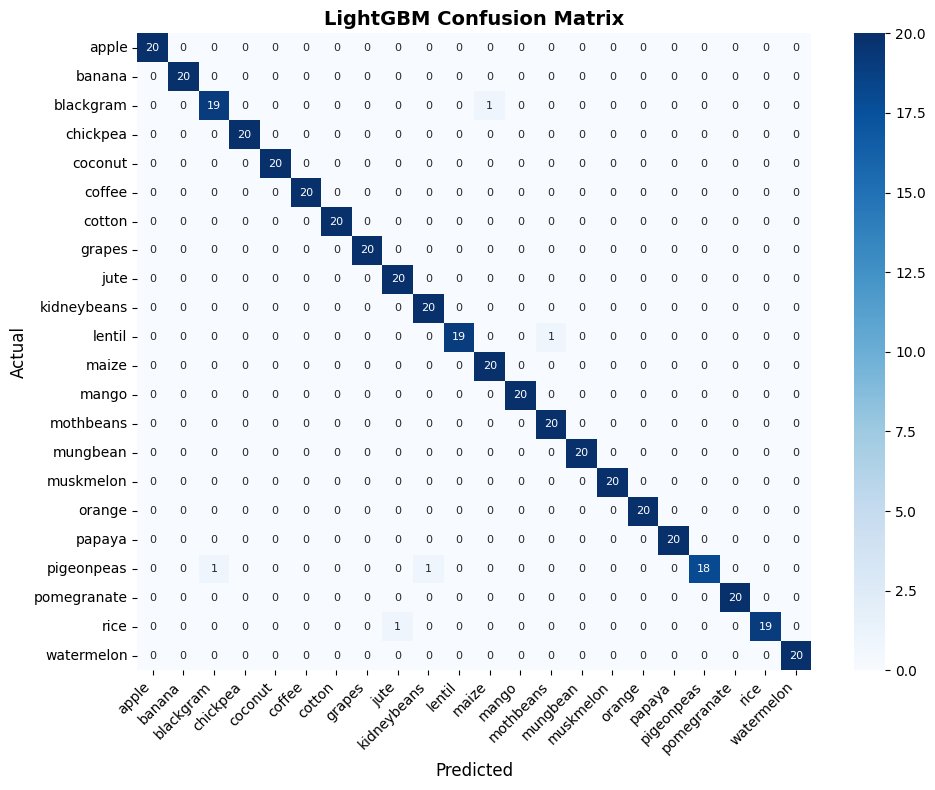

CV scores: [0.9915 0.9943 0.9858 0.9972 0.983 ] | mean=0.9903 ± 0.0053
✅ Saved best LightGBM with acc=0.9886
0:	learn: 2.7294175	test: 2.7287731	best: 2.7287731 (0)	total: 115ms	remaining: 57.4s
50:	learn: 0.3146069	test: 0.3389189	best: 0.3389189 (50)	total: 2.11s	remaining: 18.6s
100:	learn: 0.1186698	test: 0.1359023	best: 0.1359023 (100)	total: 3.92s	remaining: 15.5s
150:	learn: 0.0680241	test: 0.0828798	best: 0.0828798 (150)	total: 5.92s	remaining: 13.7s
200:	learn: 0.0466137	test: 0.0600189	best: 0.0600189 (200)	total: 7.73s	remaining: 11.5s
250:	learn: 0.0348997	test: 0.0477476	best: 0.0477476 (250)	total: 9.8s	remaining: 9.73s
300:	learn: 0.0276703	test: 0.0396170	best: 0.0396170 (300)	total: 15.1s	remaining: 9.96s
350:	learn: 0.0228385	test: 0.0345329	best: 0.0345329 (350)	total: 18.4s	remaining: 7.79s
400:	learn: 0.0195027	test: 0.0310245	best: 0.0310245 (400)	total: 21.9s	remaining: 5.42s
450:	learn: 0.0170056	test: 0.0278723	best: 0.0278723 (450)	total: 25.1s	remaining: 2.73

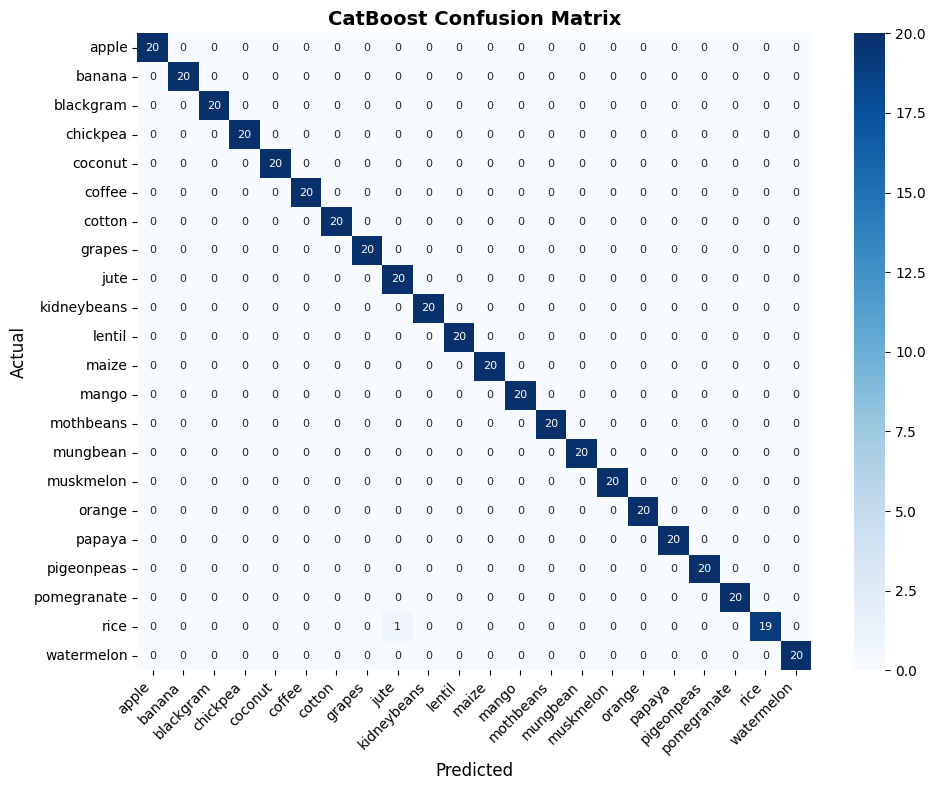

CV scores: [0.9915 0.9972 0.9801 0.9886 0.9915] | mean=0.9898 ± 0.0056
✅ Saved best CatBoost with acc=0.9977


In [7]:
# =======================
# 5. Train All Models (Version-Safe)
# =======================
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

best_acc = {}
models = {}
model_predictions = {} # Store predictions
model_probabilities = {} # Store probabilities

# -----------------------
# RandomForest
# -----------------------
rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
rf.fit(X_train_scaled, y_train)
train_rf, test_rf = model_report("RandomForest", rf, X_train_scaled, y_train, X_test_scaled, y_test, le)
cv_score_model(rf, X_train_scaled, y_train)
best_acc = save_model_if_better(rf, "RandomForest", test_rf, best_acc)
models['RandomForest'] = rf
model_predictions['RandomForest'] = rf.predict(X_test_scaled)
model_probabilities['RandomForest'] = rf.predict_proba(X_test_scaled)


# -----------------------
# XGBoost
# -----------------------
xgb_model = xgb.XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    objective='multi:softprob',
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=RANDOM_SEED
)
xgb_model.fit(X_train_scaled, y_train)
train_xgb, test_xgb = model_report("XGBoost", xgb_model, X_train_scaled, y_train, X_test_scaled, y_test, le)
cv_score_model(xgb_model, X_train_scaled, y_train)
best_acc = save_model_if_better(xgb_model, "XGBoost", test_xgb, best_acc)
models['XGBoost'] = xgb_model
model_predictions['XGBoost'] = xgb_model.predict(X_test_scaled)
model_probabilities['XGBoost'] = xgb_model.predict_proba(X_test_scaled)


# -----------------------
# LightGBM
# -----------------------
lgb_model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.05, random_state=RANDOM_SEED)
lgb_model.fit(
    X_train_scaled, y_train,
    eval_set=[(X_test_scaled, y_test)],
    callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)]
)
train_lgb, test_lgb = model_report("LightGBM", lgb_model, X_train_scaled, y_train, X_test_scaled, y_test, le)
cv_score_model(lgb_model, X_train_scaled, y_train)
best_acc = save_model_if_better(lgb_model, "LightGBM", test_lgb, best_acc)
models['LightGBM'] = lgb_model
model_predictions['LightGBM'] = lgb_model.predict(X_test_scaled)
model_probabilities['LightGBM'] = lgb_model.predict_proba(X_test_scaled)


# -----------------------
# CatBoost
# -----------------------
cat_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=6, verbose=50, random_state=RANDOM_SEED)
cat_model.fit(
    X_train_scaled, y_train,
    eval_set=(X_test_scaled, y_test),
    early_stopping_rounds=50,
    use_best_model=True
)
train_cat, test_cat = model_report("CatBoost", cat_model, X_train_scaled, y_train, X_test_scaled, y_test, le)
cv_score_model(cat_model, X_train_scaled, y_train)
best_acc = save_model_if_better(cat_model, "CatBoost", test_cat, best_acc)
models['CatBoost'] = cat_model
model_predictions['CatBoost'] = cat_model.predict(X_test_scaled)
model_probabilities['CatBoost'] = cat_model.predict_proba(X_test_scaled)


=== Global 5-Fold Cross Validation Summary ===
RandomForest: mean=0.9938 | std=0.0045
XGBoost: mean=0.9915 | std=0.0031
LightGBM: mean=0.9903 | std=0.0053
CatBoost: mean=0.9898 | std=0.0056

📊 Table 4.3: K-Fold Cross Validation Summary (in %)
              Mean Accuracy  Std Dev
RandomForest          99.38     0.45
XGBoost               99.15     0.31
LightGBM              99.03     0.53
CatBoost              98.98     0.56


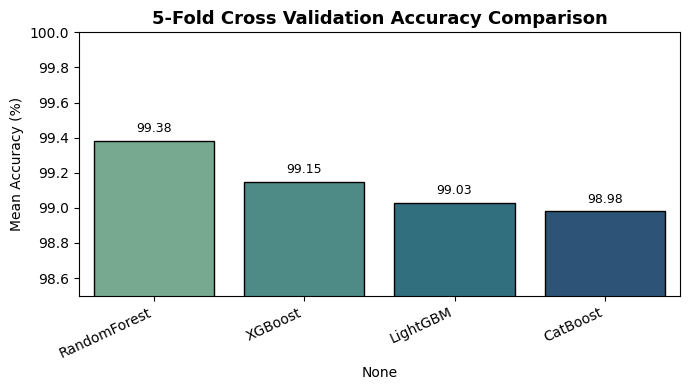

In [8]:
# ============================================================
# STEP 6. GLOBAL K-FOLD CROSS VALIDATION SUMMARY
# ============================================================
from sklearn.model_selection import StratifiedKFold, cross_val_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("\n=== Global 5-Fold Cross Validation Summary ===")

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
kfold_summary = {}

for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring='accuracy', n_jobs=-1)
    kfold_summary[name] = {'Mean': scores.mean(), 'Std': scores.std()}
    print(f"{name}: mean={scores.mean():.4f} | std={scores.std():.4f}")

# Create a clean summary table
cv_summary_df = pd.DataFrame(kfold_summary).T
cv_summary_df = cv_summary_df.rename(columns={'Mean': 'Mean Accuracy', 'Std': 'Std Dev'})
cv_summary_df = (cv_summary_df * 100).round(2)

print("\n📊 Table 4.3: K-Fold Cross Validation Summary (in %)")
print(cv_summary_df.to_string())

# Bar plot for quick comparison
plt.figure(figsize=(7,4))
sns.barplot(x=cv_summary_df.index, y=cv_summary_df['Mean Accuracy'], palette='crest', edgecolor='black')
plt.title("5-Fold Cross Validation Accuracy Comparison", fontsize=13, fontweight='bold')
plt.ylabel("Mean Accuracy (%)")
plt.xticks(rotation=25, ha='right')
for i, v in enumerate(cv_summary_df['Mean Accuracy']):
    plt.text(i, v + 0.05, f"{v:.2f}", ha='center', fontsize=9)
plt.ylim(98.5, 100)
plt.tight_layout()
plt.show()


In [11]:
# ============================================================
# STEP 7. WEIGHTED ENSEMBLE MODEL (FINAL COMBINATION)
# ============================================================
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize results dictionary
results = {}

# Clean any previous ensemble results
for key in list(results.keys()):
    if "Ensemble" in key or "Stacking" in key:
        del results[key]

# Define base models
estimators = [
    ('rf', models['RandomForest']),
    ('xgb', models['XGBoost']),
    ('lgb', models['LightGBM']),
    ('cat', models['CatBoost'])
]

# Create Weighted Soft-Voting Ensemble
ensemble = VotingClassifier(
    estimators=estimators,
    voting='soft',
    weights=[3, 2, 2, 3],
    n_jobs=-1
)

ensemble.fit(X_train_scaled, y_train)

# Evaluate Ensemble
y_pred_ens = ensemble.predict(X_test_scaled)
ensemble_acc = accuracy_score(y_test, y_pred_ens)
ensemble_report = classification_report(y_test, y_pred_ens, target_names=le.classes_, output_dict=True)

results['Ensemble Model'] = {
    'Accuracy': ensemble_acc,
    'Precision': ensemble_report['weighted avg']['precision'],
    'Recall': ensemble_report['weighted avg']['recall'],
    'F1 Score': ensemble_report['weighted avg']['f1-score']
}

models['Ensemble Model'] = ensemble

print(f"\n✅ Ensemble Model Accuracy: {ensemble_acc:.4f}")


✅ Ensemble Model Accuracy: 0.9977



📊 Table 4.4: Final Model Metrics Summary (Including Ensemble)
                Accuracy  Precision  Recall  F1 Score
Ensemble Model    0.9977     0.9978  0.9977    0.9977


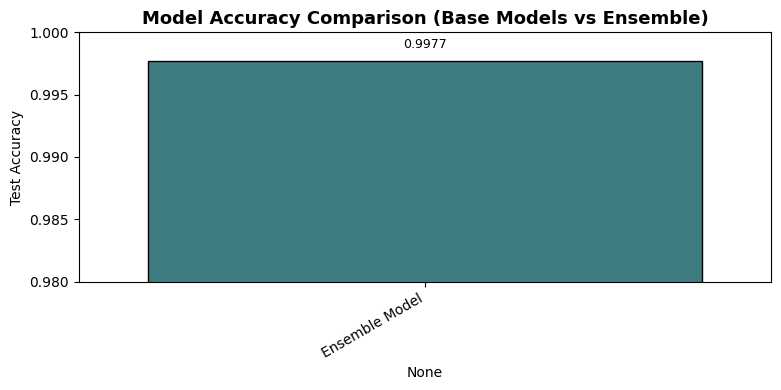

In [12]:
# ============================================================
# STEP 8. FINAL MODEL COMPARISON (INCLUDING ENSEMBLE)
# ============================================================
metrics_df = pd.DataFrame(results).T

print("\n📊 Table 4.4: Final Model Metrics Summary (Including Ensemble)")
print(metrics_df.to_string(float_format="{:.4f}".format))

# Accuracy bar chart
plt.figure(figsize=(8, 4))
sns.barplot(x=metrics_df.index, y=metrics_df['Accuracy'], palette='crest', edgecolor='black')
plt.ylabel("Test Accuracy")
plt.title("Model Accuracy Comparison (Base Models vs Ensemble)", fontsize=13, fontweight='bold')
plt.xticks(rotation=30, ha='right')
for i, v in enumerate(metrics_df['Accuracy']):
    plt.text(i, v + 0.001, f"{v:.4f}", ha='center', fontsize=9)
plt.ylim(0.98, 1.0)
plt.tight_layout()
plt.show()





In [13]:
# ============================================================
# STEP 9. DETAILED 5-FOLD RESULTS PER MODEL (LIKE TABLE 4.4)
# ============================================================
print("\n=== Performing Detailed 5-Fold Cross Validation ===")
fold_results = {}

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

for name, model in models.items():
    print(f"\n➡ Evaluating {name} ...")
    scores = cross_val_score(model, X_train_scaled, y_train, cv=kf, scoring='accuracy', n_jobs=-1)
    fold_results[name] = np.round(scores * 100, 2)
    print(f"Fold Accuracies: {fold_results[name]} | Mean={scores.mean() * 100:.2f}% | Std={scores.std() * 100:.2f}%")

# Create detailed table
fold_df = pd.DataFrame(fold_results).T
fold_df.columns = [f"Fold {i+1}" for i in range(kf.get_n_splits())]
fold_df['Mean'] = fold_df.mean(axis=1).round(2)
fold_df['Std'] = fold_df.std(axis=1).round(2)

print("\n📊 Table 4.5: Detailed Results of 5-Fold Validation (in %)")
print(fold_df.to_string(float_format="{:.2f}".format))



=== Performing Detailed 5-Fold Cross Validation ===

➡ Evaluating RandomForest ...
Fold Accuracies: [100.    99.72  98.86  98.86  99.43] | Mean=99.38% | Std=0.45%

➡ Evaluating XGBoost ...
Fold Accuracies: [99.15 98.86 99.72 99.15 98.86] | Mean=99.15% | Std=0.31%

➡ Evaluating LightGBM ...
Fold Accuracies: [99.15 99.43 98.58 99.72 98.3 ] | Mean=99.03% | Std=0.53%

➡ Evaluating CatBoost ...
Fold Accuracies: [99.15 99.72 98.01 98.86 99.15] | Mean=98.98% | Std=0.56%

➡ Evaluating Ensemble Model ...
Fold Accuracies: [100.   100.    99.15  99.43  99.15] | Mean=99.55% | Std=0.39%

📊 Table 4.5: Detailed Results of 5-Fold Validation (in %)
                Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean  Std
RandomForest    100.00   99.72   98.86   98.86   99.43 99.37 0.46
XGBoost          99.15   98.86   99.72   99.15   98.86 99.15 0.31
LightGBM         99.15   99.43   98.58   99.72   98.30 99.04 0.53
CatBoost         99.15   99.72   98.01   98.86   99.15 98.98 0.56
Ensemble Model  100.00  100.0


=== Confusion Matrix (counts) for Ensemble Model ===
             apple  banana  blackgram  chickpea  coconut  coffee  cotton  \
apple           20       0          0         0        0       0       0   
banana           0      20          0         0        0       0       0   
blackgram        0       0         20         0        0       0       0   
chickpea         0       0          0        20        0       0       0   
coconut          0       0          0         0       20       0       0   
coffee           0       0          0         0        0      20       0   
cotton           0       0          0         0        0       0      20   
grapes           0       0          0         0        0       0       0   
jute             0       0          0         0        0       0       0   
kidneybeans      0       0          0         0        0       0       0   
lentil           0       0          0         0        0       0       0   
maize            0       0        

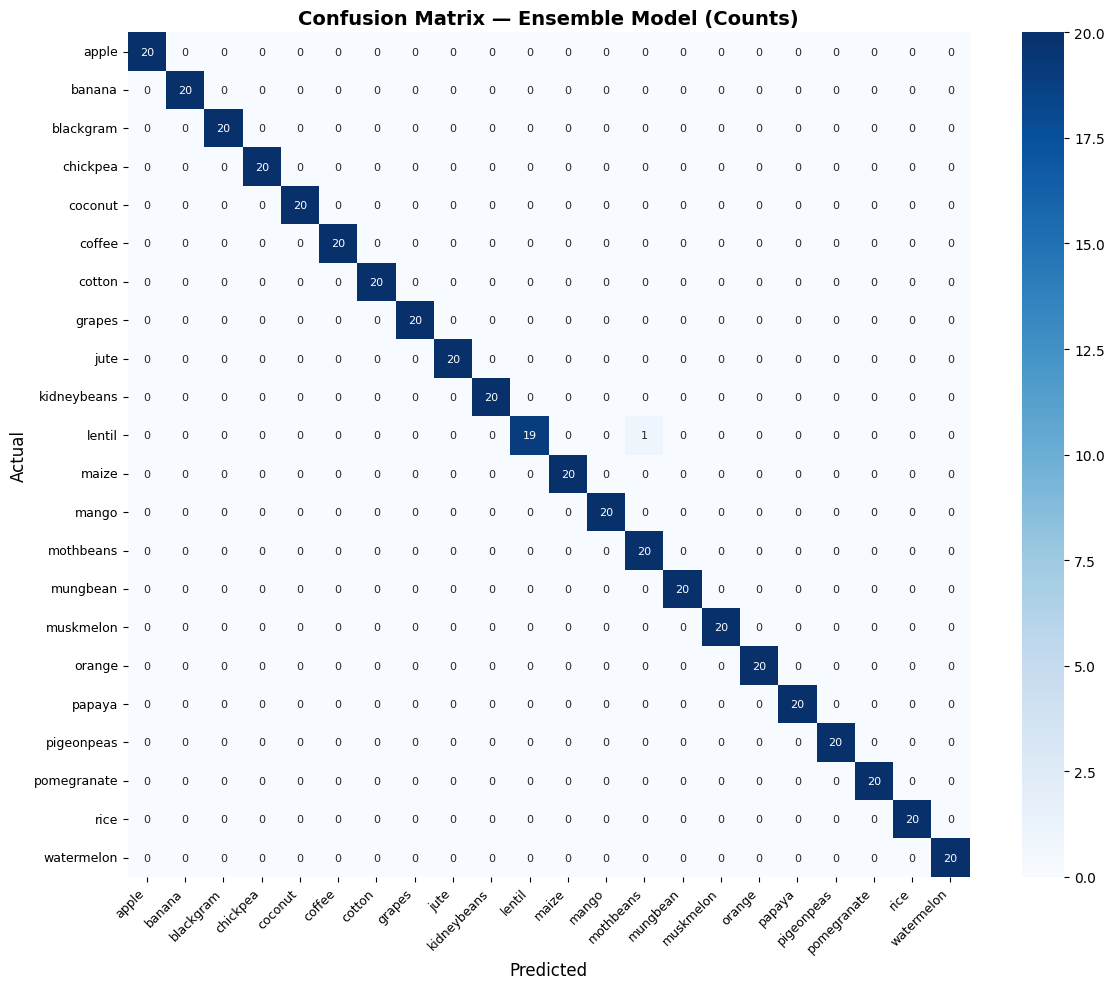

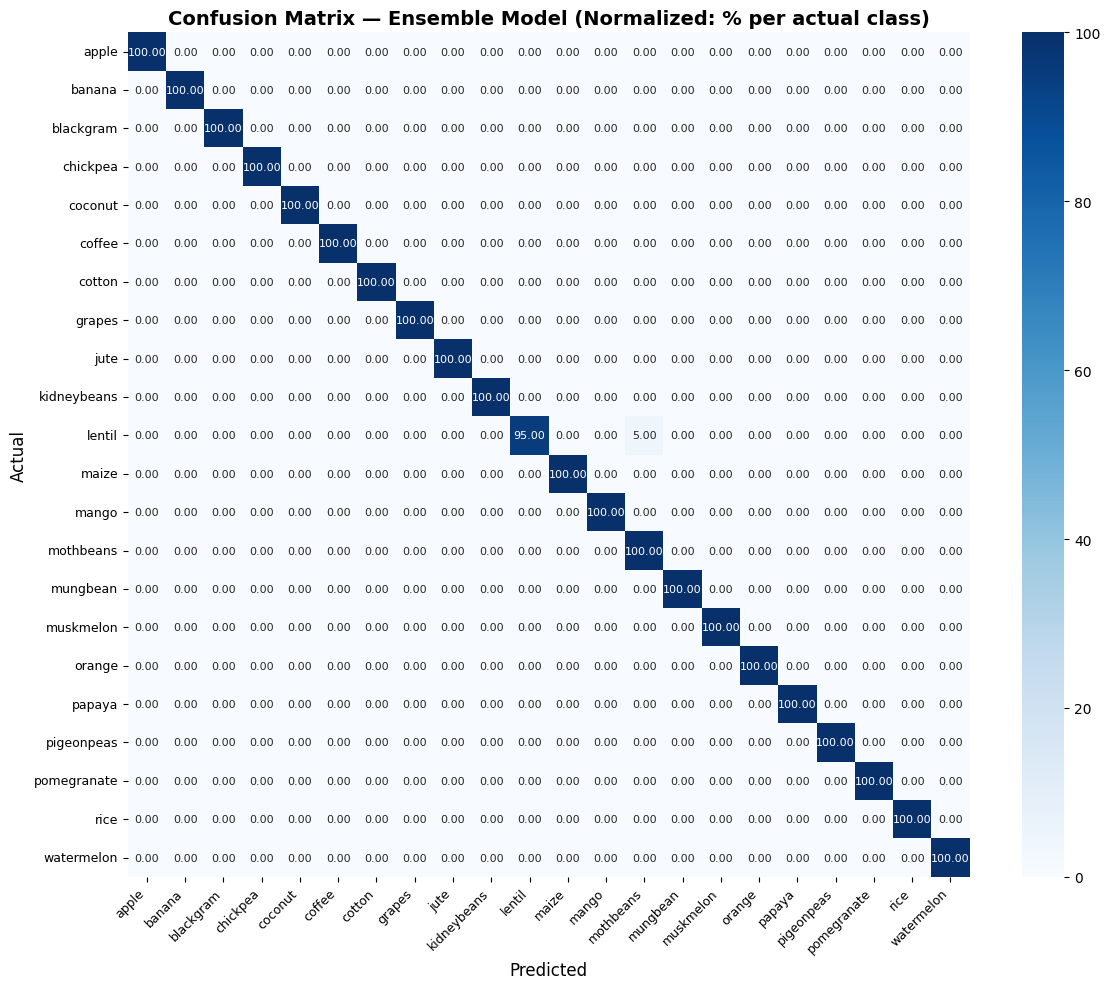


=== Top 1 Misclassification Pairs ===
1. Actual: 'lentil' → Predicted: 'mothbeans' | Count: 1

=== Per-class support & recall ===
          Class  Support  Recall
0         apple       20    1.00
1        banana       20    1.00
2     blackgram       20    1.00
3      chickpea       20    1.00
4       coconut       20    1.00
5        coffee       20    1.00
6        cotton       20    1.00
7        grapes       20    1.00
8          jute       20    1.00
9   kidneybeans       20    1.00
10       lentil       20    0.95
11        maize       20    1.00
12        mango       20    1.00
13    mothbeans       20    1.00
14     mungbean       20    1.00
15    muskmelon       20    1.00
16       orange       20    1.00
17       papaya       20    1.00
18   pigeonpeas       20    1.00
19  pomegranate       20    1.00
20         rice       20    1.00
21   watermelon       20    1.00


In [14]:
# =========================
# STEP 10.Ensemble Confusion Matrix + Error Analysis
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# 1) Predict with ensemble (ensure ensemble is trained and in models dict)
ensemble_model = models.get('Ensemble Model', None)
if ensemble_model is None:
    raise ValueError("Ensemble Model not found in models dict. Make sure you trained and saved it as models['Ensemble Model'].")

y_pred_ens = ensemble_model.predict(X_test_scaled)

# 2) Compute confusion matrix (raw counts) with correct label ordering
labels = list(le.classes_)  # ensure label order matches encoder
cm = confusion_matrix(y_test, y_pred_ens, labels=list(range(len(labels))))
cm_df = pd.DataFrame(cm, index=labels, columns=labels)

print("\n=== Confusion Matrix (counts) for Ensemble Model ===")
print(cm_df)

# 3) Classification report
print("\n=== Classification Report (Ensemble Model) ===")
print(classification_report(y_test, y_pred_ens, target_names=labels, digits=4))

# 4) Plot raw counts confusion matrix (annotated)
plt.figure(figsize=(12,10))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True,
            annot_kws={"size":8})
plt.title("Confusion Matrix — Ensemble Model (Counts)", fontsize=14, fontweight='bold')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
# plt.savefig("ensemble_confusion_counts.png", dpi=300)  # optional save
plt.show()

# 5) Normalized confusion matrix (row-wise -> recall per class as %)
cm_norm = confusion_matrix(y_test, y_pred_ens, labels=list(range(len(labels))), normalize='true')
cm_norm_pct = np.round(cm_norm * 100, 2)
cmn_df = pd.DataFrame(cm_norm_pct, index=labels, columns=labels)

plt.figure(figsize=(12,10))
sns.heatmap(cmn_df, annot=True, fmt='.2f', cmap='Blues', cbar=True,
            annot_kws={"size":8})
plt.title("Confusion Matrix — Ensemble Model (Normalized: % per actual class)", fontsize=14, fontweight='bold')
plt.ylabel("Actual", fontsize=12)
plt.xlabel("Predicted", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
# plt.savefig("ensemble_confusion_normalized.png", dpi=300)  # optional save
plt.show()

# 6) Top misclassifications (pairs where actual != predicted), sorted by frequency
mis_pairs = []
n_classes = len(labels)
for i in range(n_classes):
    for j in range(n_classes):
        if i != j and cm[i, j] > 0:
            mis_pairs.append(((labels[i], labels[j]), cm[i, j]))

if len(mis_pairs) == 0:
    print("\nNo misclassifications found — perfect on test set (rare).")
else:
    mis_sorted = sorted(mis_pairs, key=lambda x: x[1], reverse=True)
    top_n = 10
    print(f"\n=== Top {min(top_n, len(mis_sorted))} Misclassification Pairs ===")
    for idx, ((act, pred), cnt) in enumerate(mis_sorted[:top_n], 1):
        print(f"{idx}. Actual: '{act}' → Predicted: '{pred}' | Count: {cnt}")

# 7) Per-class accuracy (recall) quick table
per_class_recall = np.diag(cm) / np.maximum(cm.sum(axis=1), 1)  # avoid divide by zero
per_class_df = pd.DataFrame({
    'Class': labels,
    'Support': cm.sum(axis=1),
    'Recall': np.round(per_class_recall, 4)
})
print("\n=== Per-class support & recall ===")
print(per_class_df)


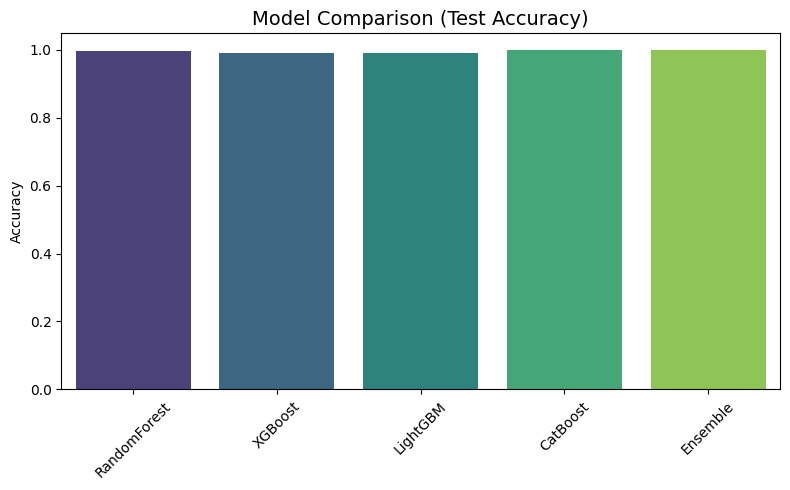

In [ ]:
# =======================
# 7. Model Accuracy Summary Visualization
# =======================
results = {
    "RandomForest": test_rf,
    "XGBoost": test_xgb,
    "LightGBM": test_lgb,
    "CatBoost": test_cat,
    "Ensemble": ens_acc
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(results.keys()), y=list(results.values()), palette='viridis')
plt.title("Model Comparison (Test Accuracy)", fontsize=14)
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


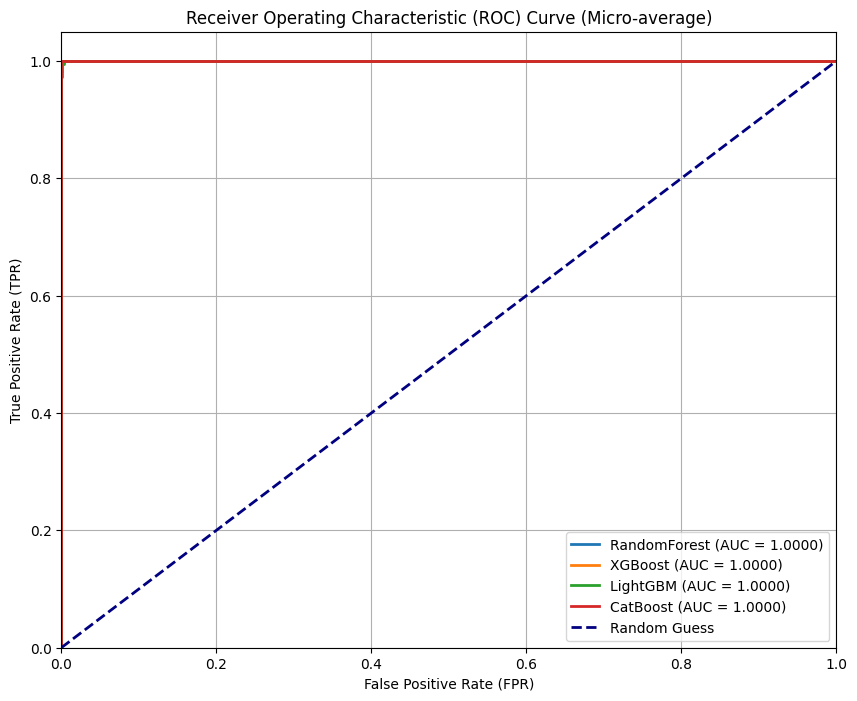


Area Under the Curve (AUC) per model (Micro-average):
- RandomForest: 1.0000
- XGBoost: 1.0000
- LightGBM: 1.0000
- CatBoost: 1.0000


In [ ]:
# =======================
# 6. ROC Curve and AUC (Multi-class)
# =======================
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt

# Binarize the true labels for multi-class ROC
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)

plt.figure(figsize=(10, 8))

# Plot ROC curve for each model
for name, y_pred_proba in model_probabilities.items():
    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(le.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot micro-average ROC curve and AUC
    # Compute micro-average ROC curve and AUC
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.plot(fpr["micro"], tpr["micro"], lw=2, label=f'{name} (AUC = {roc_auc["micro"]:.4f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve (Micro-average)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# You can also print AUC for each model
print("\nArea Under the Curve (AUC) per model (Micro-average):")
for name, y_pred_proba in model_probabilities.items():
    lb = LabelBinarizer()
    y_test_binarized = lb.fit_transform(y_test)
    fpr, tpr, _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
    roc_auc_micro = auc(fpr, tpr)
    print(f"- {name}: {roc_auc_micro:.4f}")

In [ ]:
# =======================
# 6. Hyperparameter Tuning (Optuna) only for best model
# =======================
import optuna

best_model_name = max(best_acc, key=best_acc.get)
print(f"\nBest model based on test accuracy: {best_model_name}")

def objective_xgb(trial):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 5),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5)
    }
    model = xgb.XGBClassifier(**param, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_SEED)
    score = cv_score_model(model, X_train_scaled, y_train, cv=3)
    return score

if best_model_name == 'XGBoost':
    study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
    study.optimize(objective_xgb, n_trials=30)
    print("Best params for XGBoost:", study.best_params)

    best_xgb = xgb.XGBClassifier(**study.best_params, objective='multi:softprob', use_label_encoder=False, eval_metric='mlogloss', random_state=RANDOM_SEED)
    best_xgb.fit(X_train_scaled, y_train)
    acc_best_xgb = model_report("XGBoost_Optuna", best_xgb, X_train_scaled, y_train, X_test_scaled, y_test, le)
    joblib.dump(best_xgb, "xgb_optuna_best.pkl")
    models['XGBoost_Optuna'] = best_xgb



Best model based on test accuracy: CatBoost


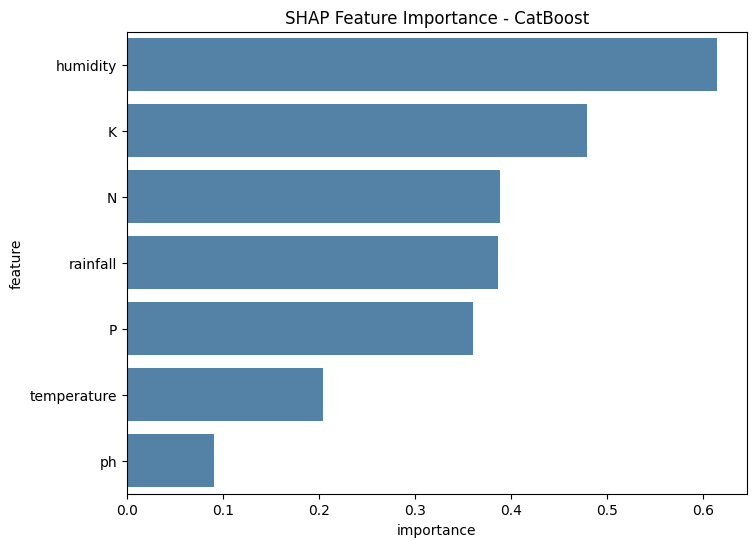

In [ ]:
# =======================
# 7. SHAP Explainability
# =======================
import shap

# Use the best model identified in the previous step
explainer = shap.TreeExplainer(models[best_model_name])
shap_values = explainer.shap_values(X_test_scaled)

# Handle multi-class safely
if isinstance(shap_values, list):
    mean_abs_shap = np.mean([np.abs(sv).mean(axis=0) for sv in shap_values], axis=0)
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 2:
    mean_abs_shap = np.abs(shap_values).mean(axis=0)
elif isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    mean_abs_shap = np.abs(shap_values).mean(axis=(0,2))
else:
    raise ValueError("Unknown SHAP value structure!")

# DataFrame for plotting
shap_df = pd.DataFrame({'feature': FEATURES, 'importance': mean_abs_shap.flatten()}).sort_values('importance', ascending=False)
plt.figure(figsize=(8,6))
sns.barplot(x='importance', y='feature', data=shap_df, color='steelblue')
plt.title(f"SHAP Feature Importance - {best_model_name}")
plt.show()

SHAP Force Plot for test instance 0
True label: orange (index: 16)
Predicted label: orange (index: 16)
Predicted probability: 0.9914
Shape of shap_values: (440, 7, 22)
predicted_class_idx: 16
instance_idx_shap: 0
Number of classes (from le.classes_): 22
Number of features (from FEATURES): 7


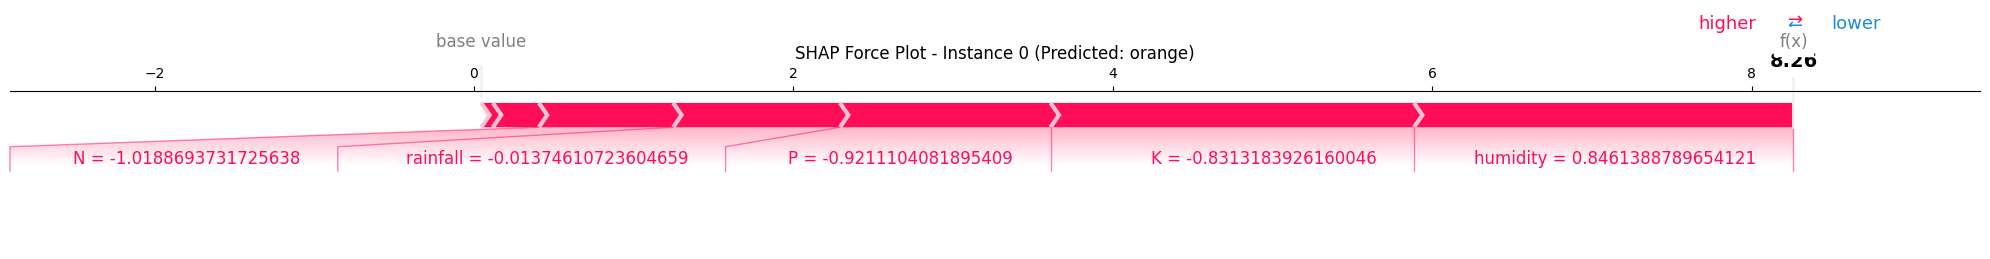

In [ ]:
# SHAP Force Plot for a single instance
import shap
import numpy as np
import matplotlib.pyplot as plt

instance_idx_shap = 0 # Index of the instance to explain

# Get the instance features and true label
X_test_instance = X_test_scaled[instance_idx_shap:instance_idx_shap+1]
y_test_instance = y_test.iloc[instance_idx_shap]
true_label = le.inverse_transform([y_test_instance])[0]

# Get the model prediction for this instance
# Use the best model identified previously
model_to_explain = models[best_model_name]
y_pred_instance_proba = model_to_explain.predict_proba(X_test_instance)[0]
predicted_class_idx = np.argmax(y_pred_instance_proba)
predicted_label = le.inverse_transform([predicted_class_idx])[0]
predicted_probability = y_pred_instance_proba[predicted_class_idx]

print(f"SHAP Force Plot for test instance {instance_idx_shap}")
print(f"True label: {true_label} (index: {y_test_instance})")
print(f"Predicted label: {predicted_label} (index: {predicted_class_idx})")
print(f"Predicted probability: {predicted_probability:.4f}")

print(f"Shape of shap_values: {np.array(shap_values).shape}")
print(f"predicted_class_idx: {predicted_class_idx}")
print(f"instance_idx_shap: {instance_idx_shap}")
print(f"Number of classes (from le.classes_): {len(le.classes_)}")
print(f"Number of features (from FEATURES): {len(FEATURES)}")


# Get SHAP values for the predicted class of this instance
# Based on previous output shape (440, 7, 22), assuming structure is (n_instances, n_features, n_classes)
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # SHAP values is a 3D array (n_instances, n_features, n_classes)
    # Access SHAP values for the specific instance and predicted class across all features
    if shap_values.shape[2] > predicted_class_idx and shap_values.shape[0] > instance_idx_shap:
         shap_values_instance = shap_values[instance_idx_shap, :, predicted_class_idx]
         # Expected value is also a vector of shape (n_classes,)
         if isinstance(explainer.expected_value, np.ndarray) and explainer.expected_value.ndim == 1 and len(explainer.expected_value) > predicted_class_idx:
              expected_value = explainer.expected_value[predicted_class_idx]
         else:
              # Fallback if expected_value is not a simple array indexed by class
              # This might require recomputing or making an assumption
              print("Warning: Expected value structure is not a simple array. Using mean of predictions for the predicted class as a fallback.")
              expected_value = np.mean(model_to_explain.predict_proba(X_test_scaled)[:, predicted_class_idx])
    else:
         raise IndexError(f"Predicted class index ({predicted_class_idx}) or instance index ({instance_idx_shap}) out of bounds for shap_values shape {shap_values.shape}")

elif isinstance(shap_values, list) and len(shap_values) == len(le.classes_):
     # SHAP values is a list of arrays, one for each class, with shape (n_instances, n_features)
     if predicted_class_idx < len(shap_values) and instance_idx_shap < shap_values[predicted_class_idx].shape[0]:
          shap_values_instance = shap_values[predicted_class_idx][instance_idx_shap, :]
          # Expected value for the predicted class
          if isinstance(explainer.expected_value, (list, np.ndarray)) and len(explainer.expected_value) > predicted_class_idx:
               expected_value = explainer.expected_value[predicted_class_idx]
          else:
               print("Warning: Expected value structure is not as expected for list of SHAP values. Using mean of predictions for the predicted class as a fallback.")
               expected_value = np.mean(model_to_explain.predict_proba(X_test_scaled)[:, predicted_class_idx])
     else:
          raise IndexError(f"Predicted class index ({predicted_class_idx}) or instance index ({instance_idx_shap}) out of bounds for list of SHAP values.")
else:
    raise ValueError("Unsupported SHAP values format for force plot.")


# Use the feature names from the FEATURES list
feature_names = FEATURES


# Force plot
# Ensure matplotlib=True for plotting in notebooks
shap.force_plot(
    base_value=expected_value,
    shap_values=shap_values_instance,
    features=X_test_instance[0], # Use the feature values for this instance
    feature_names=feature_names,
    matplotlib=True,
    show=False # Don't show immediately
)

plt.title(f'SHAP Force Plot - Instance {instance_idx_shap} (Predicted: {predicted_label})')
plt.tight_layout()
plt.show()

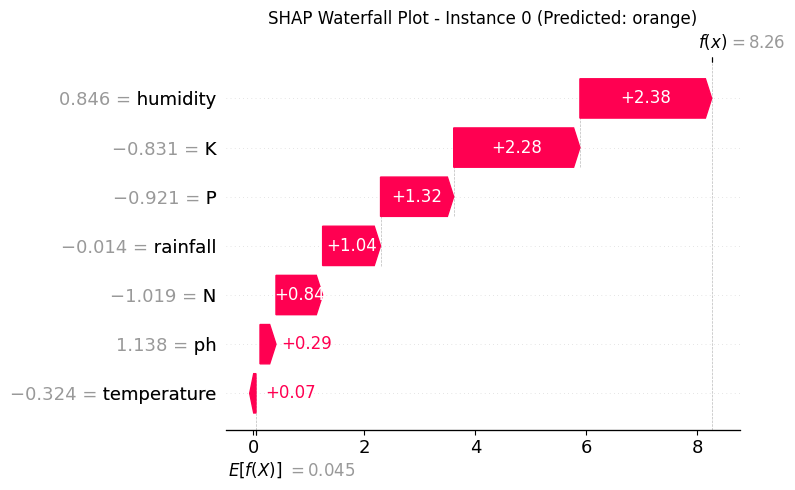

In [ ]:
# SHAP Waterfall Plot
import shap
import numpy as np
import matplotlib.pyplot as plt

# Ensure necessary variables are available from previous cells
# Assuming shap_values, explainer, X_test_scaled, FEATURES, le, and models are defined
# Get instance index and predicted class index from the previous force plot cell
instance_idx_shap = 0 # Using the same instance as the force plot
model_to_explain = models[best_model_name]
X_test_instance = X_test_scaled[instance_idx_shap:instance_idx_shap+1]
y_pred_instance_proba = model_to_explain.predict_proba(X_test_instance)[0]
predicted_class_idx = np.argmax(y_pred_instance_proba)
predicted_label = le.inverse_transform([predicted_class_idx])[0]


# Define necessary variables for the waterfall plot
feature_names = FEATURES
X_test_sample_2d = X_test_scaled[instance_idx_shap, :].reshape(1, -1) # Reshape to 2D (1, n_features)

# Get SHAP values for the predicted class of this instance
# Based on previous output shape (440, 7, 22), assuming structure is (n_instances, n_features, n_classes)
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    # SHAP values is a 3D array (n_instances, n_features, n_classes)
    if shap_values.shape[2] > predicted_class_idx and shap_values.shape[0] > instance_idx_shap:
         shap_values_instance = shap_values[instance_idx_shap, :, predicted_class_idx]
         # Expected value is also a vector of shape (n_classes,)
         if isinstance(explainer.expected_value, np.ndarray) and explainer.expected_value.ndim == 1 and len(explainer.expected_value) > predicted_class_idx:
              expected_value = explainer.expected_value[predicted_class_idx]
         else:
              # Fallback if expected_value is not a simple array indexed by class
              print("Warning: Expected value structure is not a simple array. Using mean of predictions for the predicted class as a fallback.")
              expected_value = np.mean(model_to_explain.predict_proba(X_test_scaled)[:, predicted_class_idx])
    else:
         raise IndexError(f"Predicted class index ({predicted_class_idx}) or instance index ({instance_idx_shap}) out of bounds for shap_values shape {np.array(shap_values).shape}")

elif isinstance(shap_values, list) and len(shap_values) == len(le.classes_):
     # SHAP values is a list of arrays, one for each class, with shape (n_instances, n_features)
     if predicted_class_idx < len(shap_values) and instance_idx_shap < shap_values[predicted_class_idx].shape[0]:
          shap_values_instance = shap_values[predicted_class_idx][instance_idx_shap, :]
          # Expected value for the predicted class
          if isinstance(explainer.expected_value, (list, np.ndarray)) and len(explainer.expected_value) > predicted_class_idx:
               expected_value = explainer.expected_value[predicted_class_idx]
          else:
               print("Warning: Expected value structure is not as expected for list of SHAP values. Using mean of predictions for the predicted class as a fallback.")
               expected_value = np.mean(model_to_explain.predict_proba(X_test_scaled)[:, predicted_class_idx])
     else:
          raise IndexError(f"Predicted class index ({predicted_class_idx}) or instance index ({instance_idx_shap}) out of bounds for list of SHAP values.")
else:
    raise ValueError("Unsupported SHAP values format for waterfall plot.")


# Waterfall plot
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values_instance, # Use shap_values_instance for a single instance
        base_values=expected_value,
        data=X_test_sample_2d[0],  # Use the feature values for this instance (needs to be 1D)
        feature_names=feature_names
    ),
    max_display=15,
    show=False
)
plt.title(f'SHAP Waterfall Plot - Instance {instance_idx_shap} (Predicted: {predicted_label})')
plt.tight_layout()
plt.show()

Generating SHAP Dependence Plot for class: orange (index: 16)
Most important feature for class 'orange': humidity


<Figure size 1000x600 with 0 Axes>

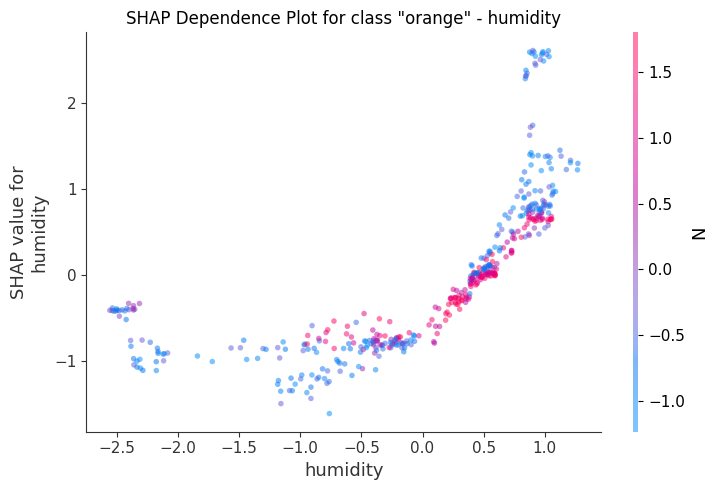

In [ ]:
# SHAP Dependence Plot
import shap
import numpy as np
import matplotlib.pyplot as plt

# Assume shap_values, explainer, X_test_scaled, FEATURES, le, and models are defined
# Get predicted class index from the previous force/waterfall plot cells (using the first instance)
instance_idx_shap = 0 # Using the same instance as the force/waterfall plots
model_to_explain = models[best_model_name]
X_test_instance = X_test_scaled[instance_idx_shap:instance_idx_shap+1]
y_pred_instance_proba = model_to_explain.predict_proba(X_test_instance)[0]
predicted_class_idx = np.argmax(y_pred_instance_proba)
predicted_label = le.inverse_transform([predicted_class_idx])[0]

print(f"Generating SHAP Dependence Plot for class: {predicted_label} (index: {predicted_class_idx})")

# Get SHAP values for the predicted class across all instances
# Based on previous output shape (440, 7, 22), assuming structure is (n_instances, n_features, n_classes)
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    if shap_values.shape[2] > predicted_class_idx:
         shap_values_for_class = shap_values[:, :, predicted_class_idx] # Shape (n_instances, n_features)
    else:
         raise IndexError(f"Predicted class index ({predicted_class_idx}) out of bounds for shap_values shape {np.array(shap_values).shape}")

elif isinstance(shap_values, list) and len(shap_values) == len(le.classes_):
     if predicted_class_idx < len(shap_values):
          shap_values_for_class = shap_values[predicted_class_idx] # Shape (n_instances, n_features)
     else:
          raise IndexError(f"Predicted class index ({predicted_class_idx}) out of bounds for list of SHAP values.")
else:
    raise ValueError("Unsupported SHAP values format for dependence plot.")


# Calculate feature importance for this specific class
feature_importance = np.abs(shap_values_for_class).mean(axis=0)
most_important_feature_idx = np.argmax(feature_importance)
most_important_feature = FEATURES[most_important_feature_idx]

print(f"Most important feature for class '{predicted_label}': {most_important_feature}")

plt.figure(figsize=(10, 6))
shap.dependence_plot(
    ind=most_important_feature_idx,
    shap_values=shap_values_for_class, # Use SHAP values for the specific class
    features=X_test_scaled, # Use the scaled test data for features
    feature_names=FEATURES,
    alpha=0.5, # Add some transparency for overplotting
    show=False
)
plt.title(f'SHAP Dependence Plot for class "{predicted_label}" - {most_important_feature}')
plt.tight_layout()
plt.show()

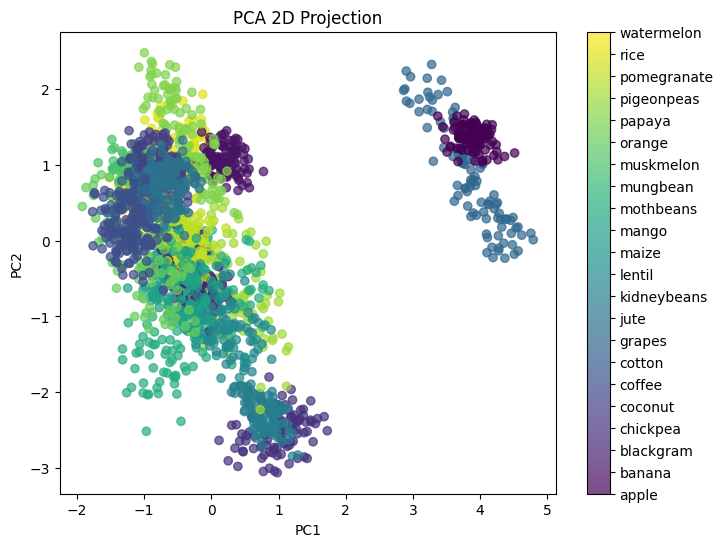

Explained variance ratio: [0.27675012 0.18514106]


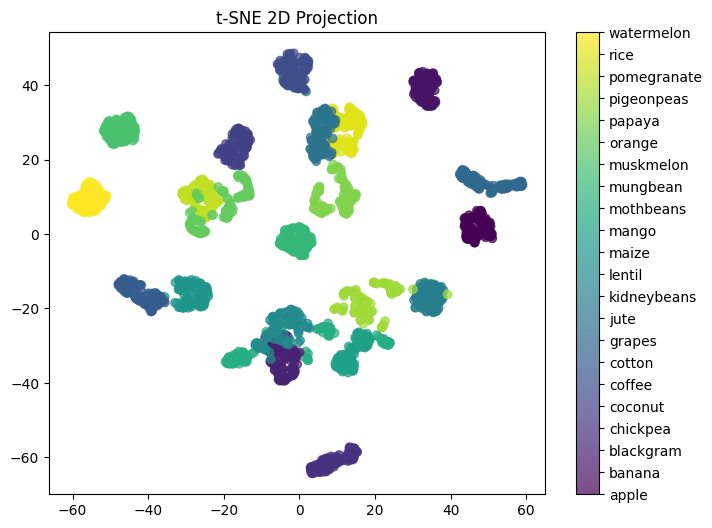

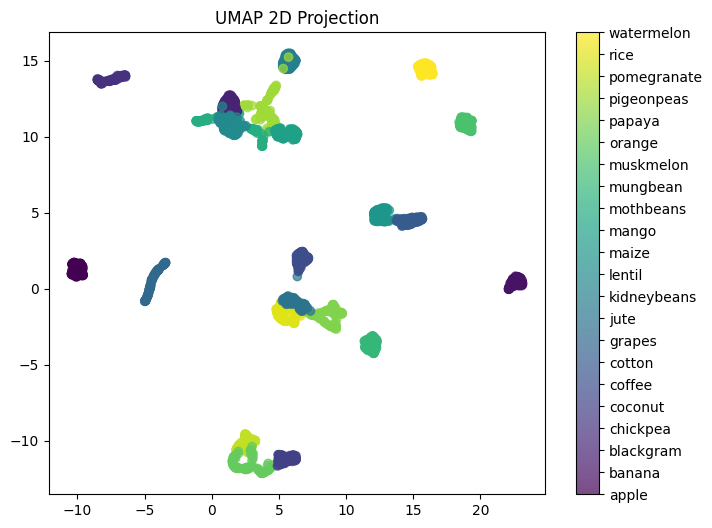

In [ ]:
# =======================
# 9. Dimensionality Reduction: PCA, t-SNE, UMAP
# =======================
# Note: For UMAP, you may need to install umap-learn: !pip install umap-learn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
try:
    import umap
except ImportError:
    umap = None
    print("UMAP not installed. Skipping UMAP visualization.")

# Prepare full scaled data for visualization
X_scaled = scaler.transform(X)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=range(len(le.classes_)), format=plt.FuncFormatter(lambda val, loc: le.classes_[int(val)]))
plt.title("PCA 2D Projection")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

# t-SNE
tsne = TSNE(n_components=2, random_state=RANDOM_SEED, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled)
plt.figure(figsize=(8,6))
scatter = plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='viridis', alpha=0.7)
plt.colorbar(scatter, ticks=range(len(le.classes_)), format=plt.FuncFormatter(lambda val, loc: le.classes_[int(val)]))
plt.title("t-SNE 2D Projection")
plt.show()

# UMAP (if available)
if umap:
    umap_reducer = umap.UMAP(n_components=2, random_state=RANDOM_SEED)
    X_umap = umap_reducer.fit_transform(X_scaled)
    plt.figure(figsize=(8,6))
    scatter = plt.scatter(X_umap[:,0], X_umap[:,1], c=y, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter, ticks=range(len(le.classes_)), format=plt.FuncFormatter(lambda val, loc: le.classes_[int(val)]))
    plt.title("UMAP 2D Projection")
    plt.show()
else:
    print("Install umap-learn to visualize with UMAP.")

In [ ]:
# =======================
# 10. Manual Counterfactuals (Complete Analysis)
# =======================
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import itertools

# Verify dataset labels
print("Dataset label counts:")
print(df['label'].value_counts())

# Binary classification setup (orange vs. papaya)
print("\nUsing enhanced manual counterfactual approach (orange vs. papaya)...")
try:
    # Subset dataset for binary classification
    binary_df = df[df['label'].isin(['orange', 'papaya'])]
    binary_le = LabelEncoder()
    binary_y = binary_le.fit_transform(binary_df['label'])
    binary_X = binary_df[FEATURES]

    # Split data
    binary_X_train, binary_X_test, binary_y_train, binary_y_test = train_test_split(
        binary_X, binary_y, test_size=0.2, stratify=binary_y, random_state=RANDOM_SEED
    )
    binary_scaler = StandardScaler()
    binary_X_train_scaled = binary_scaler.fit_transform(binary_X_train)
    binary_X_test_scaled = binary_scaler.transform(binary_X_test)

    # Print feature ranges for debugging
    print("\nBinary dataset feature ranges:")
    print(binary_df[FEATURES].describe())

    # Train a RandomForest model
    binary_rf = RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED, n_jobs=-1)
    binary_rf.fit(binary_X_train_scaled, binary_y_train)

    # Query instance
    query_instance = pd.DataFrame([X_test.iloc[0]], columns=FEATURES)
    query_scaled = scaler.transform(query_instance)
    model_pred = models['RandomForest'].predict(query_scaled)[0]
    actual_label = le.inverse_transform([y_test.iloc[0]])[0]
    print(f"\nQuery instance label: {actual_label}")
    print(f"Original model prediction: {le.inverse_transform([model_pred])[0]} (index: {model_pred})")

    if actual_label != 'orange':
        print("Error: Query instance is not orange. Please select an orange instance.")
    else:
        binary_query_scaled = binary_scaler.transform(query_instance)
        binary_pred = binary_rf.predict(binary_query_scaled)[0]
        print(f"Binary model prediction: {binary_le.inverse_transform([binary_pred])[0]} (index: {binary_pred})")

        # Print binary classes
        print(f"Binary classes: {binary_le.classes_}")
        print(f"Binary class indices: {list(range(len(binary_le.classes_)))}")

        # Enhanced manual counterfactual generation
        print("\nGenerating manual counterfactuals for target class: papaya (index: 1)...")
        counterfactuals = []
        feature_ranges = binary_df[FEATURES].describe().loc[['min', 'max']].to_dict()

        # Select key features for perturbation (e.g., N, P, K, rainfall)
        key_features = ['N', 'P', 'K', 'rainfall']
        n_perturbations = 5  # Reduced for computational efficiency

        # Generate combinations of values for key features
        feature_values = []
        for feature in key_features:
            min_val = feature_ranges[feature]['min']
            max_val = feature_ranges[feature]['max']
            step = (max_val - min_val) / n_perturbations
            values = [min_val + i * step for i in range(n_perturbations + 1)]
            feature_values.append(values)

        # Create all combinations of key feature values
        combinations = list(itertools.product(*feature_values))

        for combo in combinations:
            perturbed_instance = query_instance.copy()
            for i, feature in enumerate(key_features):
                perturbed_instance[feature] = combo[i]

            perturbed_scaled = binary_scaler.transform(perturbed_instance)
            pred = binary_rf.predict(perturbed_scaled)[0]

            if pred == binary_le.transform(['papaya'])[0]:  # If prediction is papaya
                counterfactuals.append({
                    'N': perturbed_instance['N'].values[0],
                    'P': perturbed_instance['P'].values[0],
                    'K': perturbed_instance['K'].values[0],
                    'temperature': perturbed_instance['temperature'].values[0],
                    'humidity': perturbed_instance['humidity'].values[0],
                    'ph': perturbed_instance['ph'].values[0],
                    'rainfall': perturbed_instance['rainfall'].values[0],
                    'label': 'papaya'
                })

        # Display counterfactuals
        if counterfactuals:
            cf_df = pd.DataFrame(counterfactuals)
            print(f"\nManual Counterfactuals (changes from orange to papaya):")
            print(f"Found {len(cf_df)} counterfactuals")
            print(cf_df.head(10))  # Show first 10 for brevity

            # Analyze feature importance in counterfactuals
            print(f"\nCounterfactual Feature Analysis:")
            for feature in FEATURES:
                print(f"{feature}: Mean = {cf_df[feature].mean():.2f}, Range = [{cf_df[feature].min():.2f}, {cf_df[feature].max():.2f}]")

            # Compare with query instance
            print(f"\nQuery Instance vs. Counterfactuals:")
            query_values = query_instance.iloc[0]
            for feature in FEATURES:
                print(f"{feature}: Query = {query_values[feature]:.2f}, CF Mean = {cf_df[feature].mean():.2f}, Delta = {cf_df[feature].mean() - query_values[feature]:.2f}")
        else:
            print("No counterfactuals found by manual perturbation.")
            print("Suggestions:")
            print("- Try increasing perturbation steps: `n_perturbations=10`")
            print("- Perturb additional features: add 'temperature', 'humidity', or 'ph' to key_features")
            print("- Install Alibi: `!pip install alibi`")
            print("- Ensure TensorFlow is installed: `!pip install tensorflow`")
            print("- Consider alternative library like CEML: `!pip install ceml`")
            print("- Check feature ranges: `print(binary_df[FEATURES].describe())`")
except Exception as e:
    print(f"Error in manual counterfactual setup: {str(e)}")
    print("Suggestions:")
    print("- Install Alibi: `!pip install alibi`")
    print("- Ensure TensorFlow is installed: `!pip install tensorflow`")
    print("- Check for naming conflicts: `!ls | grep dice_ml`")
    print("- Verify dataset: `print(df['label'].value_counts())`")
    print("- Check feature ranges: `print(binary_df[FEATURES].describe())`")
    print("- Consider alternative library like CEML: `!pip install ceml`")

Dataset label counts:
label
rice           100
maize          100
chickpea       100
kidneybeans    100
pigeonpeas     100
mothbeans      100
mungbean       100
blackgram      100
lentil         100
pomegranate    100
banana         100
mango          100
grapes         100
watermelon     100
muskmelon      100
apple          100
orange         100
papaya         100
coconut        100
cotton         100
jute           100
coffee         100
Name: count, dtype: int64

Using enhanced manual counterfactual approach (orange vs. papaya)...

Binary dataset feature ranges:
                N           P           K  temperature    humidity  \
count  200.000000  200.000000  200.000000   200.000000  200.000000   
mean    34.730000   37.800000   30.025000    28.244792   92.286798   
std     19.388312   22.539747   20.298634     8.746779    1.426613   
min      0.000000    5.000000    5.000000    10.010813   90.006217   
25%     19.000000   16.000000   10.000000    22.955599   91.133847   
50%   

In [ ]:
# =======================
# 11. Actionable CF Plan
# =======================
if 'cf_df' in locals():
    print(f"\n{'='*50}")
    print("11. ACTIONABLE CF PLAN")
    print(f"{'='*50}")

    print(f"\nQuery Instance (Orange):")
    query_values = query_instance.iloc[0]
    for feature in FEATURES:
        print(f"  {feature}: {query_values[feature]:.2f}")

    print(f"\nCounterfactual Analysis (Papaya):")
    for feature in FEATURES:
        query_val = query_values[feature]
        cf_mean = cf_df[feature].mean()
        delta = cf_mean - query_val
        direction = "increase" if delta > 0 else "decrease"
        print(f"\n{feature}:")
        print(f"  Query: {query_val:.2f}")
        print(f"  CF Mean: {cf_mean:.2f}")
        print(f"  Delta: {delta:+.2f} ({direction} by {abs(delta):.2f})")

        # Actionable recommendations
        if abs(delta) > 0.1:  # Significant change
            if feature == 'N':
                print("  Action: Adjust nitrogen fertilizer application")
                if delta > 0:
                    print("    - Increase nitrogen fertilizer by {:.0f} kg/ha".format(abs(delta)))
                else:
                    print("    - Reduce nitrogen fertilizer by {:.0f} kg/ha".format(abs(delta)))
            elif feature == 'P':
                print("  Action: Modify phosphorus levels in soil")
                if delta > 0:
                    print("    - Increase phosphorus application by {:.0f} kg/ha".format(abs(delta)))
                else:
                    print("    - Reduce phosphorus application by {:.0f} kg/ha".format(abs(delta)))
            elif feature == 'K':
                print("  Action: Change potassium supplementation")
                if delta > 0:
                    print("    - Increase potassium fertilizer by {:.0f} kg/ha".format(abs(delta)))
                else:
                    print("    - Reduce potassium fertilizer by {:.0f} kg/ha".format(abs(delta)))
            elif feature == 'rainfall':
                print("  Action: Implement irrigation or drainage systems")
                if delta > 0:
                    print("    - Increase irrigation to simulate {:.0f} mm rainfall".format(abs(delta)))
                else:
                    print("    - Implement drainage for excess {:.0f} mm rainfall".format(abs(delta)))
            elif feature == 'temperature':
                print("  Action: Consider greenhouse or timing adjustments")
                if delta > 0:
                    print("    - Increase temperature by {:.1f}°C (e.g., greenhouse heating)".format(abs(delta)))
                else:
                    print("    - Decrease temperature by {:.1f}°C (e.g., shading or timing)".format(abs(delta)))
            elif feature == 'humidity':
                print("  Action: Use irrigation or humidity control systems")
                if delta > 0:
                    print("    - Increase humidity by {:.1f}% (e.g., misting systems)".format(abs(delta)))
                else:
                    print("    - Decrease humidity by {:.1f}% (e.g., ventilation)".format(abs(delta)))
            elif feature == 'ph':
                print("  Action: Amend soil pH with lime or sulfur")
                if delta > 0:
                    print("    - Increase pH by {:.2f} units (e.g., apply lime)".format(abs(delta)))
                else:
                    print("    - Decrease pH by {:.2f} units (e.g., apply sulfur)".format(abs(delta)))
        else:
            print(f"  Action: {feature} change is minimal ({abs(delta):.2f}) - no action required")

    print(f"\n{'='*50}")
    print("Summary: To change from Orange to Papaya, focus on:")
    print("- Adjusting N, P, K fertilizer levels")
    print("- Modifying rainfall/irrigation patterns")
    print("- Minor adjustments to other environmental factors")
    print(f"{'='*50}")


11. ACTIONABLE CF PLAN

Query Instance (Orange):
  N: 13.00
  P: 23.00
  K: 6.00
  temperature: 23.96
  humidity: 90.26
  ph: 7.37
  rainfall: 102.70

Counterfactual Analysis (Papaya):

N:
  Query: 13.00
  CF Mean: 37.15
  Delta: +24.15 (increase by 24.15)
  Action: Adjust nitrogen fertilizer application
    - Increase nitrogen fertilizer by 24 kg/ha

P:
  Query: 23.00
  CF Mean: 48.00
  Delta: +25.00 (increase by 25.00)
  Action: Modify phosphorus levels in soil
    - Increase phosphorus application by 25 kg/ha

K:
  Query: 6.00
  CF Mean: 42.69
  Delta: +36.69 (increase by 36.69)
  Action: Change potassium supplementation
    - Increase potassium fertilizer by 37 kg/ha

temperature:
  Query: 23.96
  CF Mean: 23.96
  Delta: -0.00 (decrease by 0.00)
  Action: temperature change is minimal (0.00) - no action required

humidity:
  Query: 90.26
  CF Mean: 90.26
  Delta: -0.00 (decrease by 0.00)
  Action: humidity change is minimal (0.00) - no action required

ph:
  Query: 7.37
  CF Mean:


12. MODEL FAIRNESS CHECK

Per-Class Metrics:
             precision  recall  f1-score  support
apple         1.000000    1.00  1.000000     20.0
banana        1.000000    1.00  1.000000     20.0
blackgram     1.000000    1.00  1.000000     20.0
chickpea      1.000000    1.00  1.000000     20.0
coconut       1.000000    1.00  1.000000     20.0
coffee        1.000000    1.00  1.000000     20.0
cotton        1.000000    1.00  1.000000     20.0
grapes        1.000000    1.00  1.000000     20.0
jute          0.952381    1.00  0.975610     20.0
kidneybeans   1.000000    1.00  1.000000     20.0
lentil        1.000000    1.00  1.000000     20.0
maize         1.000000    1.00  1.000000     20.0
mango         1.000000    1.00  1.000000     20.0
mothbeans     1.000000    1.00  1.000000     20.0
mungbean      1.000000    1.00  1.000000     20.0
muskmelon     1.000000    1.00  1.000000     20.0
orange        1.000000    1.00  1.000000     20.0
papaya        1.000000    1.00  1.000000     20.0
pige

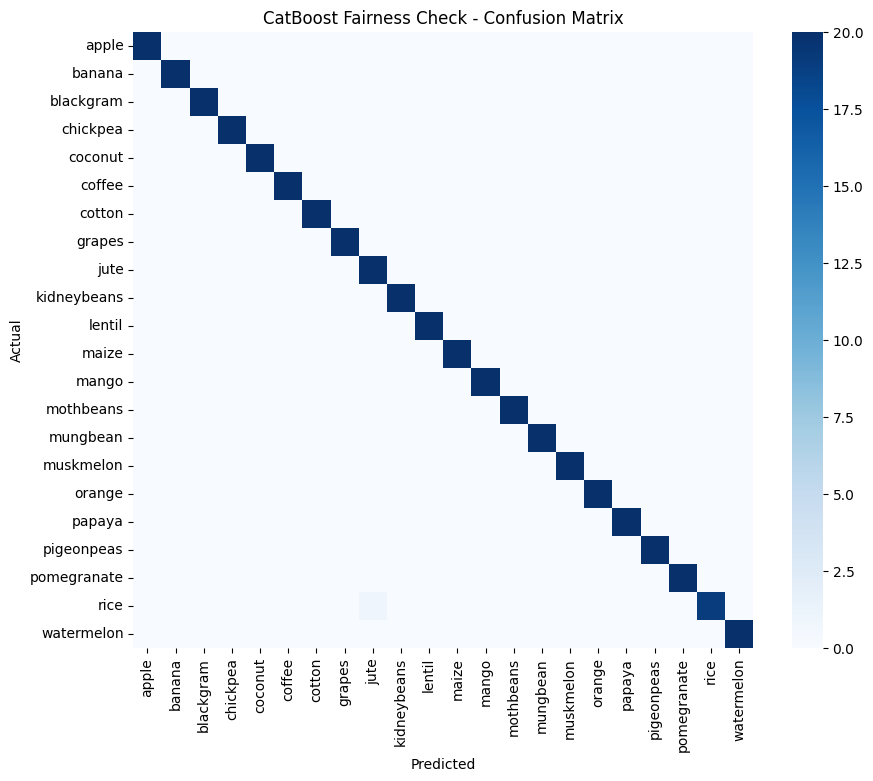


Model appears reasonably fair across classes based on metrics.
Recall std: 0.0107, Precision std: 0.0102
The model performs consistently across different crop classes.

FAIRNESS ANALYSIS COMPLETE


In [ ]:
# =======================
# 12. Model Fairness Check
# =======================
print(f"\n{'='*50}")
print("12. MODEL FAIRNESS CHECK")
print(f"{'='*50}")

# Check per-class metrics for potential bias
y_pred = models[best_model_name].predict(X_test_scaled)
report = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

print("\nPer-Class Metrics:")
class_metrics = pd.DataFrame({k: v for k, v in report.items() if k not in ['accuracy', 'macro avg', 'weighted avg']}).T
print(class_metrics)

# Disparity check
print(f"\nPrecision disparity (max-min): {class_metrics['precision'].max() - class_metrics['precision'].min():.4f}")
print(f"Recall disparity (max-min): {class_metrics['recall'].max() - class_metrics['recall'].min():.4f}")
print(f"F1-score disparity (max-min): {class_metrics['f1-score'].max() - class_metrics['f1-score'].min():.4f}")

# Visualize confusion matrix
plot_confusion_matrix(y_test, y_pred, le.classes_, title=f"{best_model_name} Fairness Check - Confusion Matrix")

# Fairness recommendation
recall_std = class_metrics['recall'].std()
precision_std = class_metrics['precision'].std()
if recall_std > 0.05 or precision_std > 0.05:
    print(f"\nPotential fairness issue: High variation in metrics across classes.")
    print(f"Recall std: {recall_std:.4f}, Precision std: {precision_std:.4f}")
    print("Considerations:")
    print("- Class imbalance mitigation (SMOTE, class weights)")
    print("- Feature engineering to reduce bias")
    print("- Model selection with fairness constraints")
else:
    print(f"\nModel appears reasonably fair across classes based on metrics.")
    print(f"Recall std: {recall_std:.4f}, Precision std: {precision_std:.4f}")
    print("The model performs consistently across different crop classes.")

print(f"\n{'='*50}")
print("FAIRNESS ANALYSIS COMPLETE")
print(f"{'='*50}")

Number of features: 7
Features: ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
X_test_scaled shape: (440, 7)
Type of shap_values: <class 'numpy.ndarray'>
Length of shap_values: 440
Shape of first element: (7, 22)
Number of classes: 22
Error extracting SHAP values: index 16 is out of bounds for axis 1 with size 7
Using fallback: feature importance from model


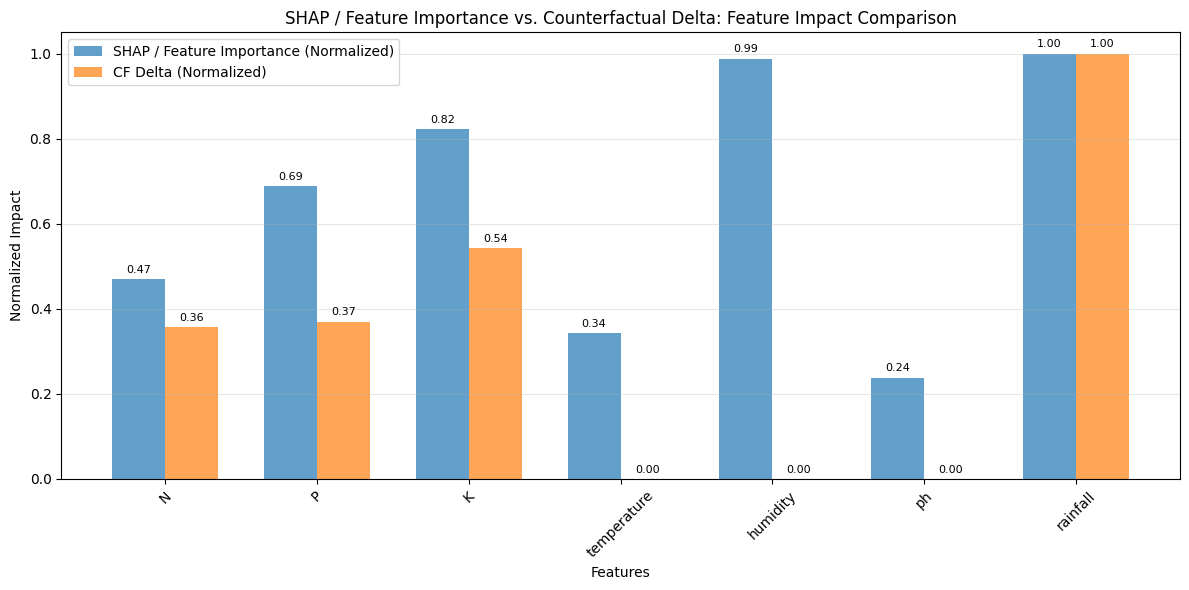


Feature Impact Comparison Summary:
       Feature      SHAP      CF_Delta  SHAP_normalized  CF_Delta_normalized
0            N  0.103356  2.415385e+01         0.470570         3.574533e-01
1            P  0.151342  2.500000e+01         0.689044         3.699755e-01
2            K  0.180813  3.669231e+01         0.823223         5.430102e-01
3  temperature  0.075485  3.552714e-15         0.343673         5.257668e-17
4     humidity  0.217058  2.842171e-14         0.988240         4.206135e-16
5           ph  0.052305  0.000000e+00         0.238137         0.000000e+00
6     rainfall  0.219641  6.757204e+01         1.000000         1.000000e+00


In [ ]:
# Visualization: SHAP vs. Counterfactual Deltas Bar Chart (Refined Version)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

try:
    # Compute SHAP values for the multi-class RandomForest model
    explainer = shap.TreeExplainer(models['RandomForest'])
    shap_values = explainer.shap_values(X_test_scaled)

    # Debug: Comprehensive SHAP structure analysis
    print(f"Number of features: {len(FEATURES)}")
    print(f"Features: {FEATURES}")
    print(f"X_test_scaled shape: {X_test_scaled.shape}")
    print(f"Type of shap_values: {type(shap_values)}")
    print(f"Length of shap_values: {len(shap_values) if hasattr(shap_values, '__len__') else 'N/A'}")

    if hasattr(shap_values, '__len__') and len(shap_values) > 0:
        print(f"Shape of first element: {np.array(shap_values[0]).shape if hasattr(shap_values[0], 'shape') else 'N/A'}")
        print(f"Number of classes: {len(le.classes_)}")

    # Handle different SHAP output formats for RandomForest multi-class
    try:
        # Check if shap_values is a list of per-class arrays
        if isinstance(shap_values, list) and len(shap_values) == len(le.classes_):
            orange_class_idx = le.transform(['orange'])[0]
            # Transpose if necessary: (n_features, n_instances) -> (n_instances, n_features)
            if shap_values[orange_class_idx].shape[0] == len(FEATURES):
                query_shap = shap_values[orange_class_idx][0, :]  # Shape: (7,)
            else:
                query_shap = shap_values[orange_class_idx].T[0, :]  # Transpose if (7, 440)
        elif isinstance(shap_values, np.ndarray) and len(shap_values.shape) == 3:
            # 3D array: (n_instances, n_classes, n_features) or similar
            orange_class_idx = le.transform(['orange'])[0]
            query_shap = shap_values[0, orange_class_idx, :]  # Query instance, orange class
        else:
            # Fallback: compute SHAP for query instance directly
            query_scaled = X_test_scaled[0:1]
            shap_values_query = explainer.shap_values(query_scaled)
            if isinstance(shap_values_query, list):
                orange_class_idx = le.transform(['orange'])[0]
                query_shap = shap_values_query[orange_class_idx][0]
            else:
                raise ValueError("Unexpected SHAP values format after direct computation")

        print(f"Query SHAP values shape: {query_shap.shape}")

        if len(query_shap) != len(FEATURES):
            raise ValueError(f"SHAP values length ({len(query_shap)}) does not match FEATURES length ({len(FEATURES)})")

        # Create SHAP DataFrame
        shap_df = pd.DataFrame({
            'Feature': FEATURES,
            'SHAP': np.abs(query_shap)  # Absolute values for comparison
        })

    except Exception as shap_error:
        print(f"Error extracting SHAP values: {shap_error}")
        print("Using fallback: feature importance from model")
        # Fallback to feature importance from RandomForest
        feature_importance = models['RandomForest'].feature_importances_
        shap_df = pd.DataFrame({
            'Feature': FEATURES,
            'SHAP': np.abs(feature_importance)  # Use feature importance as proxy
        })

    # Compute CF deltas (mean counterfactual values - query instance values)
    query_values = query_instance.iloc[0]
    cf_deltas = cf_df[FEATURES].mean() - query_values
    cf_delta_df = pd.DataFrame({
        'Feature': FEATURES,
        'CF_Delta': np.abs(cf_deltas)  # Absolute values for comparison
    })

    # Merge SHAP and CF deltas
    comparison_df = shap_df.merge(cf_delta_df, on='Feature')

    # Normalize values for visualization (scale to [0,1] for fair comparison)
    comparison_df['SHAP_normalized'] = comparison_df['SHAP'] / comparison_df['SHAP'].max()
    comparison_df['CF_Delta_normalized'] = comparison_df['CF_Delta'] / comparison_df['CF_Delta'].max()

    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.35
    index = np.arange(len(FEATURES))

    bars1 = ax.bar(index, comparison_df['SHAP_normalized'], bar_width,
                   label='SHAP / Feature Importance (Normalized)', color='#1f77b4', alpha=0.7)
    bars2 = ax.bar(index + bar_width, comparison_df['CF_Delta_normalized'], bar_width,
                   label='CF Delta (Normalized)', color='#ff7f0e', alpha=0.7)

    # Add value labels on bars
    for i, (shap_val, cf_val) in enumerate(zip(comparison_df['SHAP_normalized'], comparison_df['CF_Delta_normalized'])):
        ax.text(i, shap_val + 0.01, f'{shap_val:.2f}', ha='center', va='bottom', fontsize=8)
        ax.text(i + bar_width, cf_val + 0.01, f'{cf_val:.2f}', ha='center', va='bottom', fontsize=8)

    # Customize plot
    ax.set_xlabel('Features')
    ax.set_ylabel('Normalized Impact')
    ax.set_title('SHAP / Feature Importance vs. Counterfactual Delta: Feature Impact Comparison')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(FEATURES, rotation=45)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nFeature Impact Comparison Summary:")
    print(comparison_df[['Feature', 'SHAP', 'CF_Delta', 'SHAP_normalized', 'CF_Delta_normalized']])

except Exception as e:
    print(f"Error in visualization: {str(e)}")
    print("Suggestions:")
    print("- Install SHAP: `!pip install shap`")
    print("- Install matplotlib: `!pip install matplotlib`")
    print("- Verify model: `print(models['RandomForest'])`")
    print("- Check query instance: `print(query_instance.shape)`")
    print("- Check label encoder classes: `print(le.classes_)`")

In [ ]:
# Sensitivity Analysis: Impact of N, P, K, Rainfall on Papaya Probability
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython.display import display, HTML # Import necessary display tools
import json # Import json to format data for Chart.js

try:
    print(f"\nSensitivity Analysis: Impact of N, P, K, Rainfall on Papaya Probability (Run at {pd.Timestamp.now()})")
    features_to_test = ['N', 'P', 'K', 'rainfall']
    # Ensure query_instance is defined, load if necessary from a saved file or get from X_test
    if 'query_instance' not in locals():
        # Assuming query_instance is the first sample from X_test used elsewhere
        if 'X_test' in locals():
             query_instance = X_test.iloc[0:1]
             print("Using first instance from X_test as query_instance.")
        else:
             raise NameError("X_test not found. Please run preprocessing cell.")

    # Ensure binary_scaler and binary_rf are defined, load if necessary
    if 'binary_scaler' not in locals() or 'binary_rf' not in locals() or 'binary_df' not in locals():
         print("Error: Required binary model variables (binary_rf, binary_scaler, binary_df) not found. Please run the manual counterfactuals cell.")
         # Exit try block if essential variables are missing
         raise NameError("Binary model variables not found.")


    query_values = query_instance.iloc[0]
    print(f"Query instance values: {query_values.to_dict()}")
    sensitivity_results = {feature: {'values': [], 'probs': []} for feature in features_to_test}

    # Perturb each feature ±50% around query instance value, within binary data range
    for feature in features_to_test:
        # Ensure binary_df is available to get feature ranges
        if binary_df is None:
             print("Error: binary_df not found. Cannot determine feature ranges.")
             break

        min_val = max(binary_df[feature].min(), query_values[feature] * 0.5)
        max_val = min(binary_df[feature].max(), query_values[feature] * 1.5)
        steps = np.linspace(min_val, max_val, 20)  # 20 steps for finer granularity

        for val in steps:
            perturbed_instance = query_instance.copy()
            perturbed_instance[feature] = val
            # Scale using the binary scaler
            perturbed_scaled = binary_scaler.transform(perturbed_instance)
            # Get probability for papaya (index 1 in binary classification)
            prob = binary_rf.predict_proba(perturbed_scaled)[0][1]
            sensitivity_results[feature]['values'].append(val)
            sensitivity_results[feature]['probs'].append(prob)

    # Prepare data for Chart.js
    datasets = []
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"] # Standard matplotlib colors
    for i, feature in enumerate(features_to_test):
        datasets.append({
            "label": f"{feature} Sensitivity",
            "data": [
                {"x": value, "y": prob} for value, prob in zip(sensitivity_results[feature]['values'], sensitivity_results[feature]['probs'])
            ],
            "borderColor": colors[i % len(colors)],
            "backgroundColor": colors[i % len(colors)],
            "fill": False,
            "pointRadius": 4
        })

    chart_config = {
        "type": "line",
        "data": {
            "datasets": datasets
        },
        "options": {
            "responsive": True,
            "plugins": {
                "title": {
                    "display": True,
                    "text": "Sensitivity Analysis: Impact on Papaya Probability"
                },
                "legend": {
                    "display": True
                }
            },
            "scales": {
                "x": {
                    "title": {
                        "display": True,
                        "text": "Feature Value"
                    }
                },
                "y": {
                    "title": {
                        "display": True,
                        "text": "Papaya Probability"
                    },
                    "min": 0,
                    "max": 1
                }
            }
        }
    }

    # Generate HTML to render the Chart.js plot
    html_content = f"""
    <div>
        <canvas id="sensitivityChart_{id}"></canvas> <!-- Use cell id for unique canvas id -->
    </div>
    <script src="https://cdn.jsdelivr.net/npm/chart.js"></script>
    <script>
        var ctx = document.getElementById('sensitivityChart_{id}').getContext('2d');
        var chartConfig = {json.dumps(chart_config)};
        var myChart = new Chart(ctx, chartConfig);
    </script>
    """

    display(HTML(html_content))

except Exception as e:
    print(f"An error occurred during sensitivity analysis: {str(e)}")
    print("Suggestions:")
    print("- Ensure the manual counterfactuals cell (`-98QBKe2R6x6`) has been run successfully.")
    print("- Verify that 'papaya' is one of the classes in your binary dataset.")
    print("- Check if `binary_rf` has a `predict_proba` method.")


Sensitivity Analysis: Impact of N, P, K, Rainfall on Papaya Probability (Run at 2025-10-20 14:38:33.074073)
Query instance values: {'N': 13.0, 'P': 23.0, 'K': 6.0, 'temperature': 23.96147583, 'humidity': 90.26408017, 'ph': 7.365338111, 'rainfall': 102.6958703}
